In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

# ### Scikit-Learn ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics

from pyannote.audio.pipelines import VoiceActivityDetection

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [2]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [3]:
def get_audio_talk_duration(path_to_subj_conv):
    path_to_audios = path_to_subj_conv + "/Audios/"
    all_audios = os.listdir(path_to_audios)

    delta_talk_list = []
    for i_audio, audio in enumerate(all_audios):
        try:
            vad = silence_detection_pipeline(path_to_audios + audio)
        except:
            print("Bad audio", path_to_audios + audio)
            delta_talk_list.append(np.nan)

        seg_timeline = list(vad.get_timeline().segments_set_)
        
        if len(seg_timeline) > 0:
            start_time = np.min([seg.start for seg in seg_timeline])
            end_time = np.max([seg.end for seg in seg_timeline])

            delta_time_human_talk = end_time - start_time
            delta_talk_list.append(delta_time_human_talk)
        else:
            delta_talk_list.append(np.nan)
    
    return delta_talk_list

In [4]:
path_to_convs = "D:/GuardarDatosLableniBOT"

all_df_list = []
for subj in os.listdir(path_to_convs)[:]:
    if "User" in subj:
        print("Subject", subj, end="\r")
        path_to_conv_2 = path_to_convs + "/" + subj + "/" + subj + "_Conversations/"
        for file in os.listdir(path_to_conv_2):
            if "User" in file:
                path_to_subj_conv = path_to_conv_2 + file
                # try:
                csv_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]
                df_x = pd.read_csv(path_to_subj_conv + "/" + csv_name, sep=";")
                if df_x.shape[0] > 2:

                    df_x["DeltaHumanTalk"] = np.nan
                    delta_talk_list = get_audio_talk_duration(path_to_subj_conv)
                    d_talk_nona_list = [t for t in delta_talk_list if not np.isnan(t)]
                    source_person = df_x["Source"] == "Person"
                    if np.sum(source_person) < len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list[:np.sum(source_person)]
                    elif np.sum(source_person) == len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list
                    else:
                        for _ in range(np.sum(source_person) - len(d_talk_nona_list)):
                            d_talk_nona_list.append(np.nan)
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list

                    all_df_list.append(df_x)
                # except:
                    # print("Bad subject", path_to_subj_conv + "/" + csv_name)

Bad audio D:/GuardarDatosLableniBOT/User_01_CB/User_01_CB_Conversations/User_01_CB_20221116_100942/Audios/Subject_User_01_CB_T=8.wav
Bad audio D:/GuardarDatosLableniBOT/User_01_CB/User_01_CB_Conversations/User_01_CB_20221116_101436/Audios/Subject_User_01_CB_T=5.wav
Bad audio D:/GuardarDatosLableniBOT/User_03_CB/User_03_CB_Conversations/User_03_CB_20221116_141720/Audios/Subject_User_03_CB_T=10.wav
Bad audio D:/GuardarDatosLableniBOT/User_03_CB/User_03_CB_Conversations/User_03_CB_20221116_143608/Audios/Subject_User_03_CB_T=11.wav
Bad audio D:/GuardarDatosLableniBOT/User_05_CB/User_05_CB_Conversations/User_05_CB_20221117_121148/Audios/Subject_User_05_CB_T=9.wav
Bad audio D:/GuardarDatosLableniBOT/User_06_CB/User_06_CB_Conversations/User_06_CB_20221117_151809/Audios/Subject_User_06_CB_T=8.wav
Bad audio D:/GuardarDatosLableniBOT/User_07_CB/User_07_CB_Conversations/User_07_CB_20221118_100438/Audios/Subject_User_07_CB_T=12.wav
Bad audio D:/GuardarDatosLableniBOT/User_07_CB/User_07_CB_Conversa

IndexError: list index out of range

'Mi nombre es Jorge ¿Cómo te llamas? ; Hola Ana Maria. Estoy enfadado hoy porque pedí un aumento de sueldo y no se lo concedieron. A este ritmo, no podré llegar a fin de mes. ; Sí, supongo que tienes razón. Pero es frustrante trabajar duro y no poder tener un poco más de dinero para hacer las cosas que me gustan. ; Sí, supongo que tienes razón. A veces es mejor cambiar de trabajo y tener menos sueldo, pero al menos así tendría más tiempo libre para hacer las cosas que me gustan. ; Actúo en teatro. ; Sí, parece que cada vez hay menos interés en el teatro y es una pena, porque es muy gratificante. ; Sí, es una pena que cada vez haya menos interés en el teatro y en las artes en general. Es muy triste que la gente no valore todo el trabajo y el esfuerzo que se pone en estas actividades. ; Sí, creo que estamos en una época en la que todo es muy incierto y no hay muchas oportunidades. Es una pena que la gente no valore el trabajo de las personas que trabajan en el teatro y en las artes en ge

In [35]:
result_process_data_list = []
for data in all_df_list:
    
    personality, gender, _ = data["ConfigName"].iloc[0].split("_")
    
    gender = "Female" if gender == "Woman" else gender
    gender = "Male" if gender == "Man" else gender
    
    human_time_talk = (data["PersonTalkEndUnix"] - data["PersonTalkStartUnix"]).dropna().values
    bot_time_talk = (data["BotTalkEndUnix"] - data["BotTalkStartUnix"]).dropna().values
    conv_time = (data["UnixTimeSave"].iloc[-1] - data["UnixTimestampLoopInit"].iloc[0])/60
    max_num_pair_sentence = 1 + np.max([
        label for label in data["ConversationSentenceId"].unique() if np.sum(data["ConversationSentenceId"] == label) == 2
    ])
    
    all_vh_text = data[data["Source"] == "Bot"]["SpanishMessage"].values
    num_words_vh = [len(re.findall(r'\w+', txt)) for txt in all_vh_text] 
    all_vh_text_big_str = " ; ".join(all_vh_text) 
    
    all_person_text = data[data["Source"] == "Person"]["SpanishMessage"].values
    num_words_person = [len(re.findall(r'\w+', txt)) for txt in all_person_text] 
    all_person_text_big_str = " ; ".join(all_person_text) 
    
    result_process_data_list.append({
        "SubjectId": data["SubjectId"].iloc[0],
        "VH_Name": data["ChatbotName"].iloc[0],
        "VH_Gender": gender,
        "VH_Personality": personality,
        "UnixLoopStart": data["UnixTimestampLoopInit"].iloc[0],
        "MeanHumanTime_s": np.mean(human_time_talk),
        "StdHumanTime_s": np.std(human_time_talk),
        "MaxHumanTime_s": np.max(human_time_talk),
        "FromAudio_MeanHumanTime_s": np.nanmean(data["DeltaHumanTalk"]),
        "FromAudio_StdHumanTime_s": np.nanstd(data["DeltaHumanTalk"]),
        "FromAudio_MaxHumanTime_s": np.nanmax(data["DeltaHumanTalk"]),
        "FromAudio_TotalHumanTime_s": np.nansum(data["DeltaHumanTalk"]),
        "MeanVHTime_s": np.mean(bot_time_talk),
        "StdVHTime_s": np.std(bot_time_talk),
        "MaxVHTime_s": np.max(bot_time_talk),
        "TotalVHTime_s": np.max(bot_time_talk),
        "ConvTime_min": conv_time,
        "NumberOfSentences": data.shape[0],
        "MaxNumQA": max_num_pair_sentence,
        "NumSentencePerson": np.sum(data["Source"] == "Person"),
        "NumSentenceVH": np.sum(data["Source"] == "Bot"),
        "TextPerson": all_person_text_big_str,
        "NumTotalWordsPerson": np.sum(num_words_person),
        "MeanWordsPerson": np.mean(num_words_person),
        "MaxWordsPerson": np.max(num_words_person),
        "StdWordsPerson": np.std(num_words_person),
        "TextVH": all_vh_text_big_str,
        "NumTotalWordsVH": np.sum(num_words_vh),
        "MeanWordsVH": np.mean(num_words_vh),
        "MaxWordsVH": np.max(num_words_vh),
        "StdWordsVH": np.std(num_words_vh)
    })
    
df_res_process = pd.DataFrame(result_process_data_list)

In [36]:
print(df_res_process.columns)
print("Shape", df_res_process.shape)
df_res_process.head(10)

Index(['SubjectId', 'VH_Name', 'VH_Gender', 'VH_Personality', 'UnixLoopStart',
       'MeanHumanTime_s', 'StdHumanTime_s', 'MaxHumanTime_s',
       'FromAudio_MeanHumanTime_s', 'FromAudio_StdHumanTime_s',
       'FromAudio_MaxHumanTime_s', 'FromAudio_TotalHumanTime_s',
       'MeanVHTime_s', 'StdVHTime_s', 'MaxVHTime_s', 'TotalVHTime_s',
       'ConvTime_min', 'NumberOfSentences', 'MaxNumQA', 'NumSentencePerson',
       'NumSentenceVH', 'TextPerson', 'NumTotalWordsPerson', 'MeanWordsPerson',
       'MaxWordsPerson', 'StdWordsPerson', 'TextVH', 'NumTotalWordsVH',
       'MeanWordsVH', 'MaxWordsVH', 'StdWordsVH'],
      dtype='object')
Shape (300, 31)


,SubjectId,VH_Name,VH_Gender,VH_Personality,UnixLoopStart,MeanHumanTime_s,StdHumanTime_s,MaxHumanTime_s,FromAudio_MeanHumanTime_s,FromAudio_StdHumanTime_s,...,TextPerson,NumTotalWordsPerson,MeanWordsPerson,MaxWordsPerson,StdWordsPerson,TextVH,NumTotalWordsVH,MeanWordsVH,MaxWordsVH,StdWordsVH
0,User_01_CB,Laura,Female,Neutral,1.668588e+09,10.987555,5.116723,18.949747,6.252188,5.127379,...,"buenas yo soy Jesús ; yo sí, Valencia y tú ; P...",105,17.500000,44,15.019432,"Hola, mi nombre es Laura ¿Cómo te llamas tú? ;...",116,16.571429,37,10.265854
1,User_01_CB,David,Male,Neutral,1.668589e+09,7.830935,1.584070,9.427005,4.083750,2.342801,...,buenas yo soy Jesús ; Encantado mi deporte fav...,50,12.500000,23,6.873864,"Hola, mi nombre es David ¿Cómo te llamas tú? ;...",55,11.000000,16,2.607681
2,User_01_CB,María,Female,Happy,1.668589e+09,9.411009,3.463359,15.750861,4.752000,2.694755,...,hola buenas yo me llamo Jesús encantado María ...,66,13.200000,27,8.255907,"Encantada de conocerte, mi nombre es María ¿Cu...",101,20.200000,38,13.789851
3,User_01_CB,Pablo,Male,Relax,1.668589e+09,9.390276,3.389688,15.737232,5.351786,3.136928,...,"Hola, yo me llamo Jesús te gusta la playa, qué...",106,15.142857,24,6.854166,"Hola, mi nombre es Pablo ¿Cual es tu nombre? ;...",154,19.250000,41,9.443913
4,User_01_CB,Sara,Female,Sad,1.668590e+09,7.026681,1.380410,9.435585,2.630391,1.614463,...,"Hola, Sara yo soy Jesús hace un buen día, no? ...",70,8.750000,18,4.968652,"Hola, me llamo Sara ¿y tú? ; Hola Jesús, sí ha...",84,9.333333,16,4.690416
5,User_01_CB,Jorge,Male,Angry,1.668590e+09,8.156119,2.540030,12.621134,4.384125,2.928042,...,"hola, yo me llamo Jesús ; Y no has pensado en ...",65,13.000000,31,10.099505,Mi nombre es Jorge ¿Cómo te llamas? ; Estoy en...,112,18.666667,43,16.172679
6,User_02_CB,Alejandro,Male,Neutral,1.668596e+09,10.650504,7.062532,30.711790,2.964375,2.561300,...,"hola, yo soy Elena ; de aquí de Valencia ; Si ...",70,5.833333,15,4.393809,"Hola, mi nombre es Alejandro ¿Cómo te llamas t...",118,9.076923,14,3.583328
7,User_02_CB,Laura,Female,Neutral,1.668597e+09,6.619163,1.038502,9.366427,1.974375,1.371503,...,hola mi nombre es Elena ; me Valencia ; Pues m...,41,5.125000,10,2.666341,"Hola, mi nombre es Laura ¿Cómo te llamas tú? ;...",82,9.111111,14,2.685121
8,User_02_CB,Javier,Male,Happy,1.668597e+09,6.967394,1.330694,9.403758,2.148317,1.497199,...,hola Javier soy Elena ; de aquí de la ciudad ;...,63,4.846154,11,2.851347,"Encantado de conocerte, mi nombre es Javier ¿C...",86,6.142857,11,3.270149
9,User_02_CB,Lucía,Female,Relax,1.668598e+09,7.526045,1.899582,12.557345,1.979338,1.939479,...,"hola, soy Elena ; Muy bien. ; Me paseo a respi...",82,4.823529,10,3.364788,"Hola, mi nombre es Lucía ¿Cual es tu nombre? ;...",97,5.388889,14,2.831154


In [37]:
df_res_process["SubjectId"] = df_res_process["SubjectId"].replace("Alejandro", "User_10_CB")

In [38]:
print("Number of Subjects", df_res_process["SubjectId"].nunique())
print("Subjects", df_res_process["SubjectId"].unique())

Number of Subjects 50
Subjects ['User_01_CB' 'User_02_CB' 'User_03_CB' 'User_04_CB' 'User_05_CB'
 'User_06_CB' 'User_07_CB' 'User_08_CB' 'User_09_CB' 'User_10_CB'
 'User_11_CB' 'User_12_CB' 'User_13_CB' 'User_14_CB' 'User_15_CB'
 'User_16_CB' 'User_17_CB' 'User_18_CB' 'User_19_CB' 'User_20_CB'
 'User_21_CB' 'User_22_CB' 'User_23_CB' 'User_24_CB' 'User_25_CB'
 'User_26_CB' 'User_27_CB' 'User_28_CB' 'User_29_CB' 'User_30_CB'
 'User_31_CB' 'User_32_CB' 'User_33_CB' 'User_34_CB' 'User_35_CB'
 'User_36_CB' 'User_37_CB' 'User_38_CB' 'User_39_CB' 'User_40_CB'
 'User_41_CB' 'User_42_CB' 'User_43_CB' 'User_44_CB' 'User_45_CB'
 'User_46_CB' 'User_47_CB' 'User_48_CB' 'User_49_CB' 'User_50_CB']


In [39]:
df_res_process.to_csv("Results/DataConvProcessed.csv", sep=";", index=False)

In [40]:
df_res_process = pd.read_csv("Results/DataConvProcessed.csv", sep=";")

Mean FromAudio_MeanHumanTime_s = 4.0869 +/- 2.1205 ; Median = 3.7434 ; Min. =  1.1264 ; Max. =  15.0412
Mean MeanVHTime_s = 7.3142 +/- 1.9404 ; Median = 7.1978 ; Min. =  3.7716 ; Max. =  14.6599


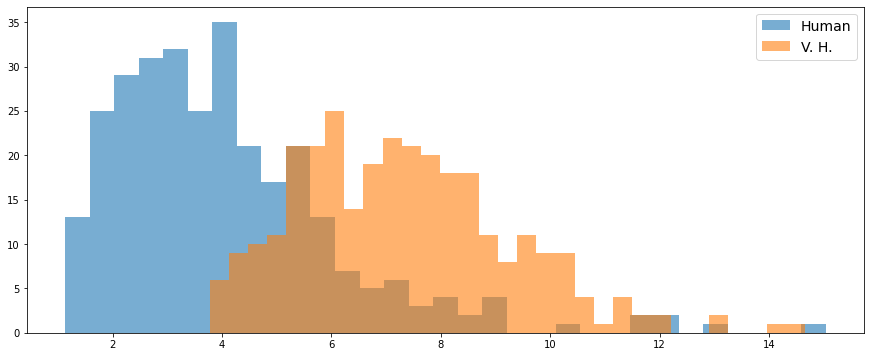

In [42]:
aute.stat_print(df_res_process["FromAudio_MeanHumanTime_s"], "FromAudio_MeanHumanTime_s")
aute.stat_print(df_res_process["MeanVHTime_s"], "MeanVHTime_s")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["FromAudio_MeanHumanTime_s"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["MeanVHTime_s"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

Mean NumSentencePerson = 10.1267 +/- 3.3542 ; Median = 10.0 ; Min. =  1 ; Max. =  18
Mean NumSentenceVH = 10.71 +/- 3.2433 ; Median = 11.0 ; Min. =  2 ; Max. =  18


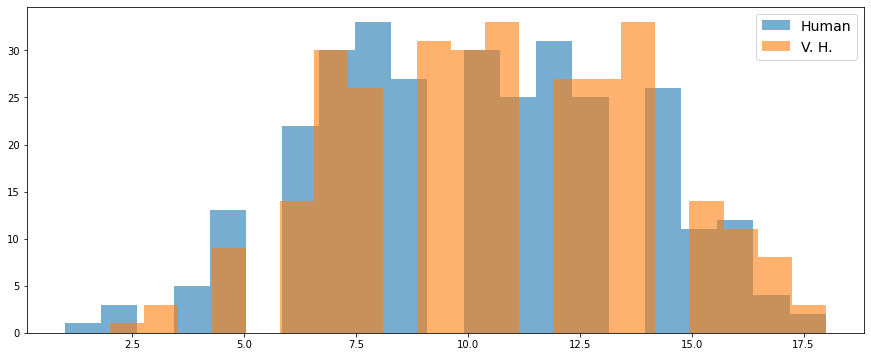

In [43]:
aute.stat_print(df_res_process["NumSentencePerson"], "NumSentencePerson")
aute.stat_print(df_res_process["NumSentenceVH"], "NumSentenceVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["NumSentencePerson"], bins=21, alpha=0.6, label="Human")
plt.hist(df_res_process["NumSentenceVH"], bins=21, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

Mean NumTotalWordsPerson = 106.8767 +/- 51.2778 ; Median = 102.0 ; Min. =  5 ; Max. =  287
Mean NumTotalWordsVH = 140.37 +/- 50.5237 ; Median = 138.0 ; Min. =  24 ; Max. =  295


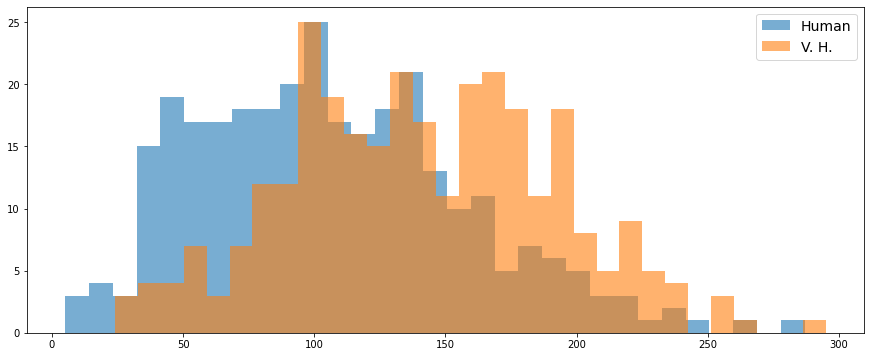

Mean MeanWordsPerson = 10.8778 +/- 5.1249 ; Median = 10.0 ; Min. =  2.5 ; Max. =  33.5
Mean MeanWordsVH = 13.7378 +/- 5.2141 ; Median = 13.0839 ; Min. =  5.2778 ; Max. =  33.5714


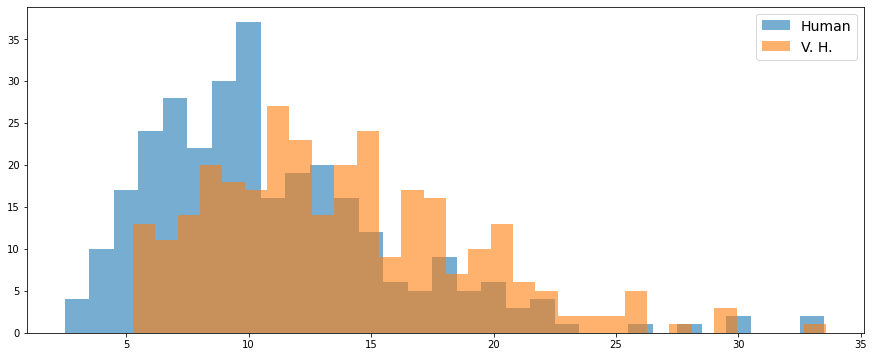

In [46]:
aute.stat_print(df_res_process["NumTotalWordsPerson"], "NumTotalWordsPerson")
aute.stat_print(df_res_process["NumTotalWordsVH"], "NumTotalWordsVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["NumTotalWordsPerson"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["NumTotalWordsVH"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

aute.stat_print(df_res_process["MeanWordsPerson"], "MeanWordsPerson")
aute.stat_print(df_res_process["MeanWordsVH"], "MeanWordsVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["MeanWordsPerson"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["MeanWordsVH"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()